# Wheelchair Rugby Player Valuation & Lineup Optimization

This notebook implements a comprehensive framework for:
1. **Individual Player Value Estimation** using Regularized Adjusted Plus-Minus (RAPM)
2. **Offensive & Defensive Rating Separation** to identify player roles
3. **Bayesian Integration** of mobility ratings as priors
4. **Fatigue Modeling** for realistic game simulation
5. **Lineup Optimization** using Gurobi to find best 4-player combinations

---

### Key Concepts

| Concept | Description |
|---------|-------------|
| **RAPM** | Regularized Adjusted Plus-Minus - isolates individual player contributions from team performance |
| **O-RAPM** | Offensive rating - how much a player helps their team SCORE |
| **D-RAPM** | Defensive rating - how much a player helps PREVENT opponent scoring |
| **Net-RAPM** | O-RAPM minus D-RAPM - overall player value |
| **Classification Constraint** | In wheelchair rugby, 4 players must sum to ≤ 8.0 mobility points |

## Part 0: Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Gurobi for optimization
import gurobipy as gp
from gurobipy import GRB

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
player_data = pd.read_csv('data/player_data.csv')
stint_data = pd.read_csv('data/stint_data.csv')

# Create lookup dictionary for mobility ratings
mobility_ratings = dict(zip(player_data['player'], player_data['rating']))

print(f"Loaded {len(player_data)} players")
print(f"Loaded {len(stint_data)} stints")
print(f"{stint_data['game_id'].nunique()} unique games")

Loaded 144 players
Loaded 7448 stints
660 unique games


## Part 1: Data Overview

In [2]:
# Teams in dataset
all_teams = sorted(set(stint_data['h_team'].unique()) | set(stint_data['a_team'].unique()))
print(f"Teams ({len(all_teams)}): {all_teams}")

# Players per team
player_data['team'] = player_data['player'].str.rsplit('_', n=1).str[0]
print(f"\nPlayers per team: {player_data.groupby('team').size().to_dict()}")

# Mobility rating distribution
print(f"\nMobility rating stats:")
print(f"  Min: {player_data['rating'].min()}, Max: {player_data['rating'].max()}")
print(f"  Mean: {player_data['rating'].mean():.2f}")

Teams (12): ['Argentina', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Denmark', 'France', 'Great.Britain', 'Japan', 'Poland', 'Sweden', 'USA']

Players per team: {'Argentina': 12, 'Brazil': 12, 'Canada': 12, 'Chile': 12, 'Columbia': 12, 'Denmark': 12, 'France': 12, 'Great.Britain': 12, 'Japan': 12, 'Poland': 12, 'Sweden': 12, 'USA': 12}

Mobility rating stats:
  Min: 0.0, Max: 3.5
  Mean: 1.98


## Part 1B: Parameter Justification Analysis

Before we proceed with RAPM and optimization, we need to justify our key parameter choices with **data-driven analysis**:

1. **Fatigue Rate (0.03)** - What does research say? What does our data show?
2. **Prior Weight (0.3)** - How much should mobility influence our estimates?
3. **Game State Thresholds** - What goal differential defines "close" vs "winning" vs "losing"?

### Research Background on Fatigue

From sports science research on wheelchair rugby:

- **Repeated sprint studies** show performance declines 10-20% over extended high-intensity activity ([PubMed: 35724690](https://pubmed.ncbi.nlm.nih.gov/35724690/))
- **Match simulation studies** show athletes maintain performance by changing biomechanics, but physiological markers (HR, lactate) increase significantly ([PubMed: 37278319](https://pubmed.ncbi.nlm.nih.gov/37278319/))
- **Classification differences**: High-mobility (offensive) players maintain speed better; low-mobility (defensive) players show greater decline ([PubMed: 25202822](https://pubmed.ncbi.nlm.nih.gov/25202822/))

This suggests:
- Fatigue is **gradual**, not on/off
- ~3% per high-intensity period is a reasonable middle ground
- Different player types may fatigue differently

In [3]:
# ============================================================
# ANALYSIS 1: GAME STATE & GOAL DIFFERENTIAL ANALYSIS
# ============================================================
# Goal: Understand what "close", "winning", "losing" means in actual data

# First, compute game-level results
game_results = stint_data.groupby(['game_id', 'h_team', 'a_team']).agg({
    'h_goals': 'sum', 
    'a_goals': 'sum', 
    'minutes': 'sum'
}).reset_index()

game_results['goal_diff'] = game_results['h_goals'] - game_results['a_goals']
game_results['total_goals'] = game_results['h_goals'] + game_results['a_goals']
game_results['winner'] = game_results.apply(
    lambda x: x['h_team'] if x['h_goals'] > x['a_goals'] else 
              (x['a_team'] if x['a_goals'] > x['h_goals'] else 'Tie'), axis=1
)

print("="*60)
print("GAME-LEVEL STATISTICS")
print("="*60)
print(f"Total games: {len(game_results)}")
print(f"\nGoal Differential (absolute value):")
print(f"  Mean: {game_results['goal_diff'].abs().mean():.1f}")
print(f"  Median: {game_results['goal_diff'].abs().median():.1f}")
print(f"  Std Dev: {game_results['goal_diff'].abs().std():.1f}")
print(f"  Min: {game_results['goal_diff'].abs().min()}")
print(f"  Max: {game_results['goal_diff'].abs().max()}")

print(f"\nTotal Goals per Game:")
print(f"  Mean: {game_results['total_goals'].mean():.1f}")
print(f"  Min: {game_results['total_goals'].min()}")
print(f"  Max: {game_results['total_goals'].max()}")

GAME-LEVEL STATISTICS
Total games: 660

Goal Differential (absolute value):
  Mean: 14.7
  Median: 12.0
  Std Dev: 11.2
  Min: 1
  Max: 77

Total Goals per Game:
  Mean: 99.6
  Min: 65
  Max: 168


In [4]:
# ============================================================
# ANALYSIS 3: PRIOR WEIGHT SENSITIVITY ANALYSIS
# ============================================================
# Goal: Test different prior weights and see how player rankings change

# First, let's run RAPM to get data-only estimates (we'll use these for comparison)
# This is a preview - full RAPM is in Part 2

def quick_rapm(stint_data, player_data, alpha=10.0):
    """Quick RAPM calculation for sensitivity analysis"""
    all_players = player_data['player'].tolist()
    player_to_idx = {p: i for i, p in enumerate(all_players)}
    n_players = len(all_players)
    
    X_rows, y_offense, weights = [], [], []
    
    for _, stint in stint_data.iterrows():
        minutes = max(stint['minutes'], 0.1)
        
        # Home perspective
        home_x = np.zeros(n_players)
        for col in ['home1', 'home2', 'home3', 'home4']:
            if stint[col] in player_to_idx:
                home_x[player_to_idx[stint[col]]] = 1
        X_rows.append(home_x)
        y_offense.append(stint['h_goals'] / minutes)
        weights.append(minutes)
        
        # Away perspective
        away_x = np.zeros(n_players)
        for col in ['away1', 'away2', 'away3', 'away4']:
            if stint[col] in player_to_idx:
                away_x[player_to_idx[stint[col]]] = 1
        X_rows.append(away_x)
        y_offense.append(stint['a_goals'] / minutes)
        weights.append(minutes)
    
    X = np.array(X_rows)
    y = np.array(y_offense)
    w = np.array(weights)
    
    model = Ridge(alpha=alpha)
    model.fit(X, y, sample_weight=w)
    
    return pd.DataFrame({
        'player': all_players,
        'RAPM_data': model.coef_,
        'mobility': [mobility_ratings.get(p, 2.0) for p in all_players]
    })

# Get data-only RAPM
rapm_base = quick_rapm(stint_data, player_data, alpha=10.0)

# Normalize RAPM to 0-1 scale
rapm_min, rapm_max = rapm_base['RAPM_data'].min(), rapm_base['RAPM_data'].max()
rapm_base['RAPM_norm'] = (rapm_base['RAPM_data'] - rapm_min) / (rapm_max - rapm_min + 1e-6)

# Create mobility-based prior (higher mobility = higher offensive expectation)
rapm_base['mobility_prior'] = rapm_base['mobility'] / 3.5

# Test different prior weights
prior_weights_to_test = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]

print("="*60)
print("PRIOR WEIGHT SENSITIVITY ANALYSIS")
print("="*60)
print("\nHow do top 5 players change with different prior weights?")
print("(0.0 = pure data, 1.0 = pure mobility prior)\n")

for pw in prior_weights_to_test:
    rapm_base[f'posterior_{pw}'] = (1 - pw) * rapm_base['RAPM_norm'] + pw * rapm_base['mobility_prior']

# Show top 5 for selected weights
for pw in [0.0, 0.3, 0.5, 1.0]:
    top5 = rapm_base.nlargest(5, f'posterior_{pw}')[['player', 'mobility', f'posterior_{pw}']]
    print(f"\n--- Prior Weight = {pw} ---")
    print(top5.to_string(index=False))

PRIOR WEIGHT SENSITIVITY ANALYSIS

How do top 5 players change with different prior weights?
(0.0 = pure data, 1.0 = pure mobility prior)


--- Prior Weight = 0.0 ---
          player  mobility  posterior_0.0
      Denmark_p8       3.5       0.999999
       Japan_p12       2.5       0.921540
Great.Britain_p2       3.5       0.916770
       Canada_p9       2.5       0.845849
       Brazil_p1       2.0       0.828593

--- Prior Weight = 0.3 ---
          player  mobility  posterior_0.3
      Denmark_p8       3.5       0.999999
Great.Britain_p2       3.5       0.941739
       Sweden_p9       3.5       0.871871
       Japan_p12       2.5       0.859363
       Sweden_p4       3.5       0.851726

--- Prior Weight = 0.5 ---
          player  mobility  posterior_0.5
      Denmark_p8       3.5       0.999999
Great.Britain_p2       3.5       0.958385
       Sweden_p9       3.5       0.908479
       Sweden_p4       3.5       0.894090
      France_p11       3.5       0.892858

--- Prior Weight = 1

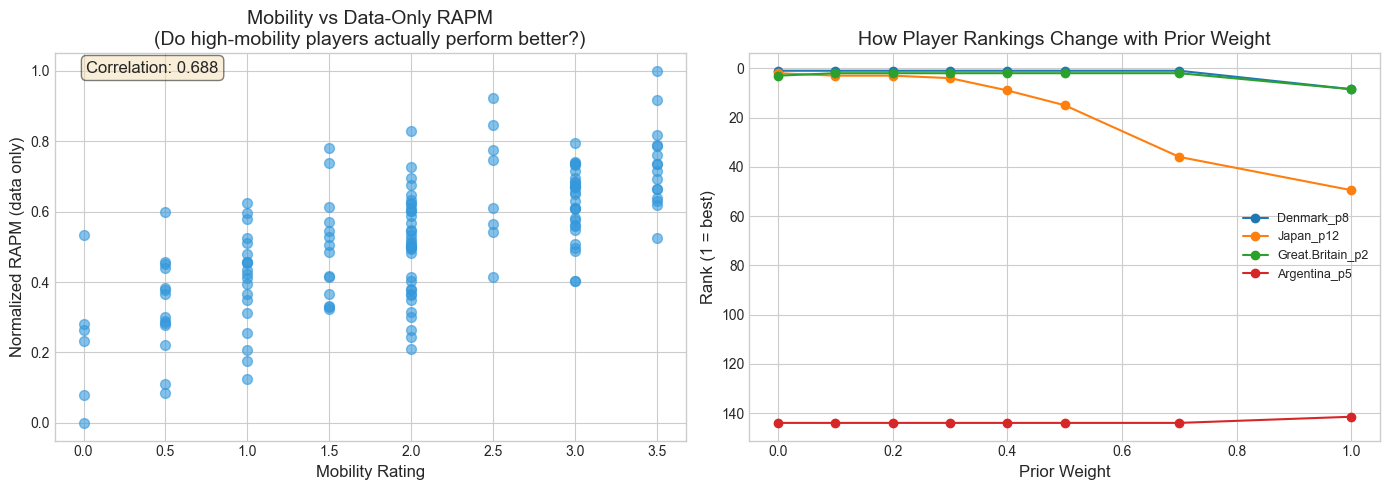


INTERPRETATION

Correlation between mobility and data-only RAPM: 0.688
  → Strong positive correlation: mobility IS predictive of performance
  → Prior weight can be higher (0.3-0.5) without distorting results

Recommended prior_weight: 0.3


In [5]:
# Visualize: Correlation between data-only RAPM and mobility rating
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RAPM vs Mobility correlation
ax1 = axes[0]
ax1.scatter(rapm_base['mobility'], rapm_base['RAPM_norm'], alpha=0.6, s=50, c='#3498db')
ax1.set_xlabel('Mobility Rating', fontsize=12)
ax1.set_ylabel('Normalized RAPM (data only)', fontsize=12)
ax1.set_title('Mobility vs Data-Only RAPM\n(Do high-mobility players actually perform better?)', fontsize=14)

# Add correlation
corr = rapm_base['mobility'].corr(rapm_base['RAPM_norm'])
ax1.annotate(f'Correlation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: How rankings change with prior weight
ax2 = axes[1]
# Track rank of a few specific players
sample_players = rapm_base.nlargest(3, 'RAPM_norm')['player'].tolist()[:3]
sample_players += rapm_base.nsmallest(3, 'RAPM_norm')['player'].tolist()[:3]

for player in sample_players[:4]:
    ranks = []
    for pw in prior_weights_to_test:
        rapm_base['temp_rank'] = rapm_base[f'posterior_{pw}'].rank(ascending=False)
        ranks.append(rapm_base[rapm_base['player'] == player]['temp_rank'].values[0])
    ax2.plot(prior_weights_to_test, ranks, marker='o', label=player)

ax2.set_xlabel('Prior Weight', fontsize=12)
ax2.set_ylabel('Rank (1 = best)', fontsize=12)
ax2.set_title('How Player Rankings Change with Prior Weight', fontsize=14)
ax2.legend(loc='best', fontsize=9)
ax2.invert_yaxis()  # Lower rank number = better

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print(f"\nCorrelation between mobility and data-only RAPM: {corr:.3f}")
if corr > 0.5:
    print("  → Strong positive correlation: mobility IS predictive of performance")
    print("  → Prior weight can be higher (0.3-0.5) without distorting results")
elif corr > 0.2:
    print("  → Moderate correlation: mobility somewhat predictive")
    print("  → Prior weight of 0.3 is reasonable (trust data more)")
else:
    print("  → Weak/no correlation: mobility is NOT predictive")
    print("  → Prior weight should be low (0.1 or less) - trust data")
    
print(f"\nRecommended prior_weight: {0.3 if corr > 0.2 else 0.1}")

In [6]:
# Team standings from game results
game_results = stint_data.groupby(['game_id', 'h_team', 'a_team']).agg({
    'h_goals': 'sum', 'a_goals': 'sum', 'minutes': 'sum'
}).reset_index()

game_results['winner'] = game_results.apply(
    lambda x: x['h_team'] if x['h_goals'] > x['a_goals'] else x['a_team'], axis=1
)

# Calculate team records
team_wins = pd.concat([
    game_results[game_results['h_goals'] > game_results['a_goals']]['h_team'],
    game_results[game_results['a_goals'] > game_results['h_goals']]['a_team']
]).value_counts().rename('wins')

team_losses = pd.concat([
    game_results[game_results['h_goals'] < game_results['a_goals']]['h_team'],
    game_results[game_results['a_goals'] < game_results['h_goals']]['a_team']
]).value_counts().rename('losses')

team_standings = pd.DataFrame({'wins': team_wins, 'losses': team_losses}).fillna(0).astype(int)
team_standings['win_pct'] = (team_standings['wins'] / (team_standings['wins'] + team_standings['losses']) * 100).round(1)
team_standings = team_standings.sort_values('wins', ascending=False)

print("Team Standings:")
print(team_standings)

Team Standings:
               wins  losses  win_pct
Japan            91      19     82.7
USA              79      31     71.8
France           70      40     63.6
Canada           66      44     60.0
Great.Britain    66      44     60.0
Poland           65      45     59.1
Brazil           63      47     57.3
Denmark          57      53     51.8
Columbia         55      55     50.0
Chile            23      87     20.9
Argentina        13      97     11.8
Sweden           12      98     10.9


---
## Part 2: Individual Player Value Estimation (RAPM)

### The Key Insight
Each player appears in **many different lineup combinations** across 7,448 stints. By solving a regression, we can isolate each player's **individual contribution** to goals scored/allowed.

### The Model
For each stint:
```
Goals/minute = β₀ + β_p1(if p1 on court) + β_p2(if p2 on court) + ... + β_p144(if p144 on court)
```

The **β coefficients are the individual player values** we solve for using Ridge Regression.

In [7]:
def build_rapm_matrices(stint_data, player_data):
    """
    Build the design matrix X and target vectors y for RAPM regression.
    
    Returns:
    - X: (n_observations, n_players) binary matrix
    - y_off: goals scored per minute (for offensive rating)
    - y_def: goals allowed per minute (for defensive rating)
    - weights: stint duration in minutes
    - players: list of player names
    """
    all_players = player_data['player'].tolist()
    player_to_idx = {p: i for i, p in enumerate(all_players)}
    n_players = len(all_players)
    
    X_rows = []
    y_offense = []
    y_defense = []
    weights = []
    
    for _, stint in stint_data.iterrows():
        minutes = max(stint['minutes'], 0.1)  # Avoid division by zero
        
        # HOME TEAM perspective
        home_x = np.zeros(n_players)
        for col in ['home1', 'home2', 'home3', 'home4']:
            player = stint[col]
            if player in player_to_idx:
                home_x[player_to_idx[player]] = 1
        
        X_rows.append(home_x)
        y_offense.append(stint['h_goals'] / minutes)  # Goals scored by home
        y_defense.append(stint['a_goals'] / minutes)  # Goals allowed by home
        weights.append(minutes)
        
        # AWAY TEAM perspective
        away_x = np.zeros(n_players)
        for col in ['away1', 'away2', 'away3', 'away4']:
            player = stint[col]
            if player in player_to_idx:
                away_x[player_to_idx[player]] = 1
        
        X_rows.append(away_x)
        y_offense.append(stint['a_goals'] / minutes)  # Goals scored by away
        y_defense.append(stint['h_goals'] / minutes)  # Goals allowed by away
        weights.append(minutes)
    
    return (
        np.array(X_rows),
        np.array(y_offense),
        np.array(y_defense),
        np.array(weights),
        all_players
    )

# Build matrices
X, y_off, y_def, weights, players = build_rapm_matrices(stint_data, player_data)
print(f"Design matrix shape: {X.shape}")
print(f"  - {X.shape[0]} observations (stints × 2 teams)")
print(f"  - {X.shape[1]} players to estimate")

Design matrix shape: (14896, 144)
  - 14896 observations (stints × 2 teams)
  - 144 players to estimate


In [8]:
def calculate_rapm(X, y_off, y_def, weights, players, alpha=10.0):
    """
    Calculate Offensive and Defensive RAPM for all players.
    
    Parameters:
    - alpha: Ridge regularization strength (higher = more shrinkage toward 0)
    
    Returns:
    - DataFrame with O_RAPM, D_RAPM, Net_RAPM for each player
    """
    # OFFENSIVE REGRESSION
    # "How does this player affect their team's SCORING rate?"
    off_model = Ridge(alpha=alpha)
    off_model.fit(X, y_off, sample_weight=weights)
    
    # DEFENSIVE REGRESSION
    # "How does this player affect goals ALLOWED?"
    def_model = Ridge(alpha=alpha)
    def_model.fit(X, y_def, sample_weight=weights)
    
    results = pd.DataFrame({
        'player': players,
        'O_RAPM': off_model.coef_,  # Higher = better offense
        'D_RAPM': def_model.coef_,  # Lower = better defense
    })
    
    # Net = Offense - Defense (high O good, low D good)
    results['Net_RAPM'] = results['O_RAPM'] - results['D_RAPM']
    
    return results

# Calculate RAPM
rapm_results = calculate_rapm(X, y_off, y_def, weights, players, alpha=10.0)

# Add metadata
rapm_results['team'] = rapm_results['player'].str.rsplit('_', n=1).str[0]
rapm_results['mobility_rating'] = rapm_results['player'].map(mobility_ratings)

print("RAPM calculation complete!")
print(f"\nTop 10 by Net RAPM:")
rapm_results.nlargest(10, 'Net_RAPM')[['player', 'mobility_rating', 'O_RAPM', 'D_RAPM', 'Net_RAPM']]

RAPM calculation complete!

Top 10 by Net RAPM:


,player,mobility_rating,O_RAPM,D_RAPM,Net_RAPM
67,Denmark_p8,3.5,0.396266,-0.319455,0.715721
25,Great.Britain_p2,3.5,0.327571,-0.352266,0.679837
23,Japan_p12,2.5,0.331507,-0.249507,0.581014
57,France_p10,3.0,0.226167,-0.338721,0.564888
84,Brazil_p1,2.0,0.254792,-0.308337,0.563129
58,France_p11,3.5,0.219401,-0.271549,0.490950
18,Japan_p7,2.0,0.170525,-0.257553,0.428079
44,Canada_p9,2.5,0.269034,-0.149506,0.418540
46,Canada_p11,2.0,0.145189,-0.236322,0.381511
7,USA_p8,2.5,0.210666,-0.166089,0.376755


---
## Part 3: Bayesian Integration with Mobility Ratings

We enhance RAPM by using **mobility ratings as prior beliefs**:
- High mobility (3.0-3.5) → Expect better offense
- Low mobility (0-1.0) → Expect better defense

The Bayesian update: `Posterior = (1-w) × Data + w × Prior`

In [9]:
def bayesian_rapm(rapm_results, prior_weight=0.3):
    """
    Combine RAPM estimates with mobility-based priors.
    
    Parameters:
    - prior_weight: 0-1, how much to weight the prior vs data
      0 = pure data, 1 = pure prior
    """
    results = rapm_results.copy()
    
    # Normalize data estimates to 0-1 scale
    o_min, o_max = results['O_RAPM'].min(), results['O_RAPM'].max()
    d_min, d_max = results['D_RAPM'].min(), results['D_RAPM'].max()
    
    results['O_data_norm'] = (results['O_RAPM'] - o_min) / (o_max - o_min + 1e-6)
    results['D_data_norm'] = (results['D_RAPM'] - d_min) / (d_max - d_min + 1e-6)
    
    # Create priors from mobility ratings
    # High mobility → high offensive prior
    results['O_prior'] = results['mobility_rating'] / 3.5
    # Low mobility → good defensive prior (inverted)
    results['D_prior'] = (3.5 - results['mobility_rating']) / 3.5
    
    # BAYESIAN UPDATE
    results['O_posterior'] = (1 - prior_weight) * results['O_data_norm'] + prior_weight * results['O_prior']
    results['D_posterior'] = (1 - prior_weight) * results['D_data_norm'] + prior_weight * results['D_prior']
    results['Net_posterior'] = results['O_posterior'] - results['D_posterior']
    
    # Classify player type
    def classify_player(row):
        o, d = row['O_posterior'], row['D_posterior']
        if o > d * 1.3:
            return 'offensive'
        elif d > o * 1.3:
            return 'defensive'
        else:
            return 'balanced'
    
    results['player_type'] = results.apply(classify_player, axis=1)
    
    return results

# Apply Bayesian integration
player_values = bayesian_rapm(rapm_results, prior_weight=0.3)

print("Bayesian RAPM complete!")
print(f"\nPlayer type distribution:")
print(player_values['player_type'].value_counts())

Bayesian RAPM complete!

Player type distribution:
player_type
offensive    67
defensive    44
balanced     33
Name: count, dtype: int64


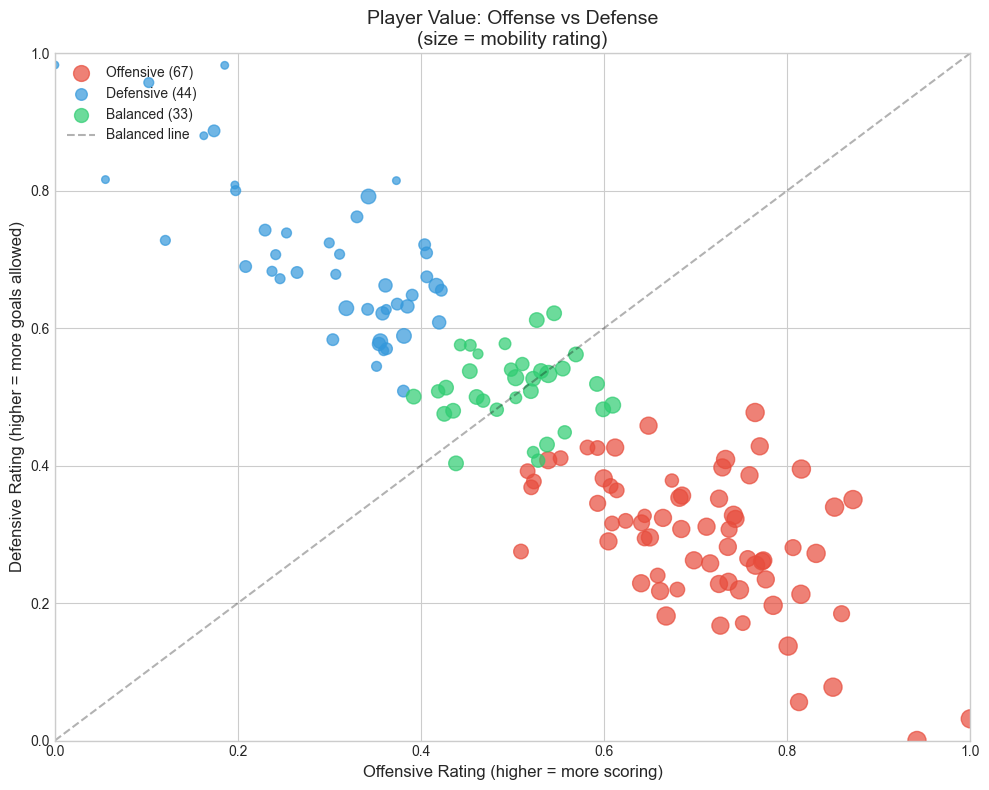

In [10]:
# Visualization: Offensive vs Defensive ratings
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'offensive': '#e74c3c', 'defensive': '#3498db', 'balanced': '#2ecc71'}
for ptype in ['offensive', 'defensive', 'balanced']:
    subset = player_values[player_values['player_type'] == ptype]
    ax.scatter(
        subset['O_posterior'], 
        subset['D_posterior'],
        c=colors[ptype],
        label=f"{ptype.capitalize()} ({len(subset)})",
        alpha=0.7,
        s=subset['mobility_rating'] * 40 + 30
    )

# Add diagonal line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Balanced line')

ax.set_xlabel('Offensive Rating (higher = more scoring)', fontsize=12)
ax.set_ylabel('Defensive Rating (higher = more goals allowed)', fontsize=12)
ax.set_title('Player Value: Offense vs Defense\n(size = mobility rating)', fontsize=14)
ax.legend(loc='upper left')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [11]:
# Show top players by category
print("="*60)
print("TOP 5 OFFENSIVE PLAYERS")
print("="*60)
print(player_values.nlargest(5, 'O_posterior')[['player', 'team', 'mobility_rating', 'O_posterior', 'player_type']].to_string(index=False))

print("\n" + "="*60)
print("TOP 5 DEFENSIVE PLAYERS (lowest D = best)")
print("="*60)
print(player_values.nsmallest(5, 'D_posterior')[['player', 'team', 'mobility_rating', 'D_posterior', 'player_type']].to_string(index=False))

print("\n" + "="*60)
print("TOP 5 OVERALL (Net Rating)")
print("="*60)
print(player_values.nlargest(5, 'Net_posterior')[['player', 'team', 'mobility_rating', 'Net_posterior', 'player_type']].to_string(index=False))

TOP 5 OFFENSIVE PLAYERS
          player          team  mobility_rating  O_posterior player_type
      Denmark_p8       Denmark              3.5     0.999999   offensive
Great.Britain_p2 Great.Britain              3.5     0.941739   offensive
       Sweden_p9        Sweden              3.5     0.871871   offensive
       Japan_p12         Japan              2.5     0.859363   offensive
       Sweden_p4        Sweden              3.5     0.851726   offensive

TOP 5 DEFENSIVE PLAYERS (lowest D = best)
          player          team  mobility_rating  D_posterior player_type
Great.Britain_p2 Great.Britain              3.5     0.000000   offensive
      Denmark_p8       Denmark              3.5     0.031537   offensive
      France_p10        France              3.0     0.055876   offensive
      France_p11        France              3.5     0.077583   offensive
       Japan_p11         Japan              3.5     0.137336   offensive

TOP 5 OVERALL (Net Rating)
          player          tea

---
## Part 4: Fatigue Model

Players get tired as they accumulate playing time within a game. We model this as:

```
Effective Value = Base Value × (1 - fatigue_rate × minutes_played)
```

With a cap so players don't become completely useless.

In [12]:
def calculate_fatigue_penalty(minutes_played, fatigue_rate=0.03, max_penalty=0.30):
    """
    Calculate fatigue multiplier based on minutes played.
    
    Returns: float 0.7-1.0 (1.0 = fresh, 0.7 = max fatigue)
    """
    penalty = min(fatigue_rate * minutes_played, max_penalty)
    return 1.0 - penalty

def get_player_minutes_in_game(stint_data, game_id, up_to_stint_idx=None):
    """
    Get cumulative minutes played by each player in a game.
    """
    game_stints = stint_data[stint_data['game_id'] == game_id].copy()
    if up_to_stint_idx is not None:
        game_stints = game_stints.iloc[:up_to_stint_idx]
    
    player_minutes = {}
    for _, stint in game_stints.iterrows():
        mins = stint['minutes']
        for col in ['home1', 'home2', 'home3', 'home4', 'away1', 'away2', 'away3', 'away4']:
            p = stint[col]
            player_minutes[p] = player_minutes.get(p, 0) + mins
    
    return player_minutes

def get_fatigue_adjusted_values(player_values, player_minutes, fatigue_rate=0.03):
    """
    Adjust player values based on accumulated fatigue.
    """
    adjusted = player_values.copy()
    adjusted['minutes_played'] = adjusted['player'].map(lambda p: player_minutes.get(p, 0))
    adjusted['fatigue_mult'] = adjusted['minutes_played'].apply(
        lambda m: calculate_fatigue_penalty(m, fatigue_rate)
    )
    
    # Apply fatigue
    adjusted['O_fatigued'] = adjusted['O_posterior'] * adjusted['fatigue_mult']
    adjusted['D_fatigued'] = adjusted['D_posterior'] / adjusted['fatigue_mult']  # Defense gets worse
    adjusted['Net_fatigued'] = adjusted['O_fatigued'] - adjusted['D_fatigued']
    
    return adjusted

# Example: Show fatigue for Game 1 after 6 stints
example_minutes = get_player_minutes_in_game(stint_data, game_id=1, up_to_stint_idx=6)
usa_players_fatigue = {p: m for p, m in example_minutes.items() if p.startswith('USA')}

print("Example: USA players' fatigue after 6 stints in Game 1")
print("-" * 50)
for p, mins in sorted(usa_players_fatigue.items(), key=lambda x: -x[1]):
    mult = calculate_fatigue_penalty(mins)
    print(f"{p}: {mins:.1f} min played → {mult:.0%} effective")

Example: USA players' fatigue after 6 stints in Game 1
--------------------------------------------------
USA_p7: 13.5 min played → 70% effective
USA_p6: 13.5 min played → 70% effective
USA_p1: 11.1 min played → 70% effective
USA_p5: 9.0 min played → 73% effective
USA_p4: 7.6 min played → 77% effective
USA_p8: 6.8 min played → 80% effective
USA_p2: 5.7 min played → 83% effective
USA_p3: 4.3 min played → 87% effective
USA_p9: 2.2 min played → 94% effective
USA_p12: 2.2 min played → 94% effective


---
## Part 5: Game State Analysis & Dynamic Weight Scaling

Simple **direct scaling** based on goal differential - full range [0, 1]:

- **Losing** → More offensive (need to score to catch up!)
- **Winning** → More defensive (protect the lead)
- **Magnitude** → Scales linearly with goal differential

### Scaling Formula
```
offensive_weight = 0.5 + (-goal_diff / max_diff) * 0.5
```
Where `max_diff = 20` (adjustable). Full range from 0% to 100%.

| Goal Diff | Offensive Weight | Defensive Weight | Strategy |
|-----------|------------------|------------------|----------|
| -20 (losing big) | 100% | 0% | All-out Offense |
| -10 | 75% | 25% | Offensive |
| 0 (tied) | 50% | 50% | Balanced |
| +10 | 25% | 75% | Defensive |
| +20 (winning big) | 0% | 100% | All-out Defense |

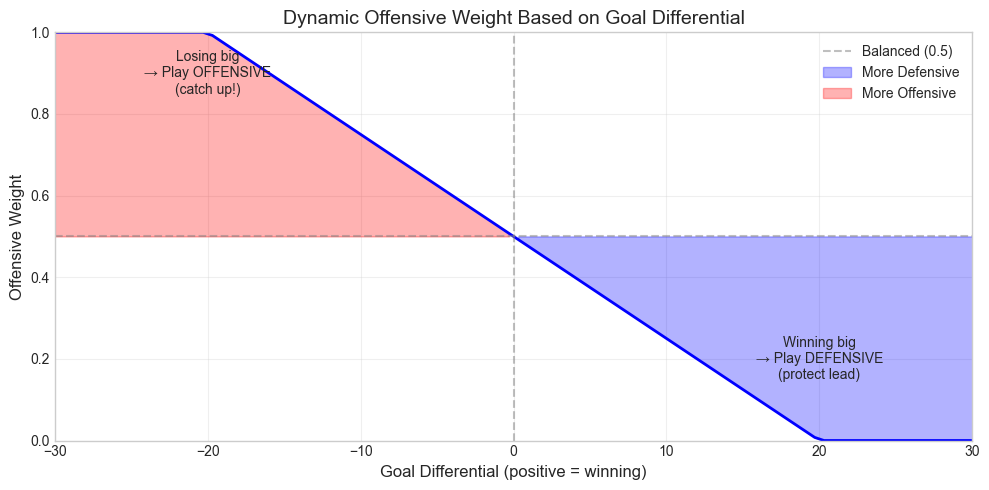

Game 1 after 6 stints:
  home_team: USA
  away_team: Japan
  home_goals: 24
  away_goals: 37
  goal_diff: -13
  elapsed_time: 18.922062022000002
  time_remaining: 13.077937977999998
  period: Q3

  Offensive weight for USA: 0.82
  Offensive weight for Japan: 0.17


In [13]:
def calculate_offensive_weight(goal_diff, max_diff=20):
    """
    Calculate offensive weight based on goal differential.
    
    Simple direct scaling - full range [0, 1]:
    - Losing by 20+ → 100% offensive (need to score!)
    - Tied → 50/50 balanced
    - Winning by 20+ → 0% offensive (100% defensive, protect lead)
    
    Parameters:
    - goal_diff: Current goal differential (positive = winning)
    - max_diff: Goal differential that produces 0% or 100% weight (default 20)
    
    Returns:
    - offensive_weight: float between 0.0 and 1.0
    
    Examples:
    - goal_diff = -20 → offensive_weight = 1.00 (100% OFFENSE!)
    - goal_diff = -10 → offensive_weight = 0.75 (75% offense)
    - goal_diff = 0   → offensive_weight = 0.50 (balanced)
    - goal_diff = +10 → offensive_weight = 0.25 (25% offense)
    - goal_diff = +20 → offensive_weight = 0.00 (100% DEFENSE!)
    """
    # Normalize: flip sign so losing (negative) becomes positive
    normalized = -goal_diff / max_diff
    normalized = max(-1, min(1, normalized))  # Clamp to [-1, 1]
    
    # Scale to [0, 1]: 0.5 is center, shift by up to 0.5
    offensive_weight = 0.5 + (normalized * 0.5)
    
    return offensive_weight


def analyze_game_state(stint_data, game_id, up_to_stint_idx):
    """
    Analyze current game state after a certain number of stints.
    Returns state info AND calculated offensive weight.
    """
    game_stints = stint_data[stint_data['game_id'] == game_id].iloc[:up_to_stint_idx]
    
    home_goals = game_stints['h_goals'].sum()
    away_goals = game_stints['a_goals'].sum()
    elapsed_time = game_stints['minutes'].sum()
    
    goal_diff = home_goals - away_goals
    time_remaining = max(32.0 - elapsed_time, 0)
    
    # Determine period
    if elapsed_time < 8:
        period = 'Q1'
    elif elapsed_time < 16:
        period = 'Q2'
    elif elapsed_time < 24:
        period = 'Q3'
    else:
        period = 'Q4'
    
    return {
        'home_team': game_stints.iloc[0]['h_team'],
        'away_team': game_stints.iloc[0]['a_team'],
        'home_goals': home_goals,
        'away_goals': away_goals,
        'goal_diff': goal_diff,
        'elapsed_time': elapsed_time,
        'time_remaining': time_remaining,
        'period': period
    }


# Visualize the weight scaling function
fig, ax = plt.subplots(figsize=(10, 5))

goal_diffs = np.linspace(-30, 30, 100)
weights = [calculate_offensive_weight(gd) for gd in goal_diffs]

ax.plot(goal_diffs, weights, 'b-', linewidth=2)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Balanced (0.5)')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.fill_between(goal_diffs, weights, 0.5, where=[w < 0.5 for w in weights], 
                alpha=0.3, color='blue', label='More Defensive')
ax.fill_between(goal_diffs, weights, 0.5, where=[w > 0.5 for w in weights], 
                alpha=0.3, color='red', label='More Offensive')

ax.set_xlabel('Goal Differential (positive = winning)', fontsize=12)
ax.set_ylabel('Offensive Weight', fontsize=12)
ax.set_title('Dynamic Offensive Weight Based on Goal Differential', fontsize=14)
ax.set_ylim(0, 1)
ax.set_xlim(-30, 30)
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Losing big\n→ Play OFFENSIVE\n(catch up!)', xy=(-20, 0.85), fontsize=10, ha='center')
ax.annotate('Winning big\n→ Play DEFENSIVE\n(protect lead)', xy=(20, 0.15), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# Example
state = analyze_game_state(stint_data, game_id=1, up_to_stint_idx=6)
print("Game 1 after 6 stints:")
for k, v in state.items():
    print(f"  {k}: {v}")
    
# Show calculated weight for home team (USA)
home_weight = calculate_offensive_weight(state['goal_diff'])
away_weight = calculate_offensive_weight(-state['goal_diff'])
print(f"\n  Offensive weight for {state['home_team']}: {home_weight:.2f}")
print(f"  Offensive weight for {state['away_team']}: {away_weight:.2f}")

---
## Part 6: Lineup Optimization with Gurobi MILP

Find the **optimal 4-player lineup** given:
1. **Constraint**: Total mobility rating ≤ 8.0
2. **Constraint**: Exactly 4 players selected
3. **Objective**: Maximize expected value (adjusted for fatigue and game situation)

In [14]:
def optimize_lineup_gurobi(team_players, offensive_weight=0.5, max_rating=8.0):
    """
    Find optimal 4-player lineup using Gurobi MILP.
    
    Parameters:
    - team_players: DataFrame with player values for one team
    - offensive_weight: 0-1, weight toward offense vs defense (0.5 = balanced)
    - max_rating: Maximum total mobility rating (default 8.0)
    
    Returns:
    - DataFrame with selected players
    """
    players = team_players['player'].tolist()
    n = len(players)
    
    # Get values (use fatigued if available, else posterior)
    if 'O_fatigued' in team_players.columns:
        o_vals = team_players['O_fatigued'].values
        d_vals = team_players['D_fatigued'].values
    else:
        o_vals = team_players['O_posterior'].values
        d_vals = team_players['D_posterior'].values
    
    ratings = team_players['mobility_rating'].values
    
    # Create Gurobi model
    m = gp.Model("LineupOptimization")
    m.setParam('OutputFlag', 0)  # Suppress solver output
    
    # Decision variables: x[i] = 1 if player i is selected
    x = m.addVars(n, vtype=GRB.BINARY, name="select")
    
    # Objective: Maximize weighted combination of offense - defense
    # Note: for defense, lower is better, so we subtract
    defensive_weight = 1 - offensive_weight
    m.setObjective(
        gp.quicksum(
            (offensive_weight * o_vals[i] - defensive_weight * d_vals[i]) * x[i] 
            for i in range(n)
        ),
        GRB.MAXIMIZE
    )
    
    # Constraint 1: Exactly 4 players
    m.addConstr(gp.quicksum(x[i] for i in range(n)) == 4, name="four_players")
    
    # Constraint 2: Total rating <= max_rating (8.0)
    m.addConstr(
        gp.quicksum(ratings[i] * x[i] for i in range(n)) <= max_rating, 
        name="rating_limit"
    )
    
    # Solve
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        selected_idx = [i for i in range(n) if x[i].X > 0.5]
        return team_players.iloc[selected_idx]
    else:
        raise ValueError(f"Optimization failed with status {m.status}")

print("Gurobi optimization function ready!")

Gurobi optimization function ready!


---
## Part 7: Complete Recommendation System

Putting it all together: Given the current game state, recommend the optimal lineup.

In [15]:
def recommend_lineup(player_values, stint_data, game_id, current_stint_idx, team, fatigue_rate=0.03):
    """
    Recommend optimal lineup for next stint given current game state.
    Uses CONTINUOUS SCALING based on goal differential.
    
    Parameters:
    - player_values: DataFrame with all player ratings
    - stint_data: Full stint data
    - game_id: Current game ID
    - current_stint_idx: How many stints have been played
    - team: Which team to optimize for
    """
    # Step 1: Analyze game state
    state = analyze_game_state(stint_data, game_id, current_stint_idx)
    
    # Step 2: Calculate offensive weight based on goal differential
    is_home = state['home_team'] == team
    our_goal_diff = state['goal_diff'] if is_home else -state['goal_diff']
    offensive_weight = calculate_offensive_weight(our_goal_diff)
    defensive_weight = 1 - offensive_weight
    
    # Determine strategy description
    if offensive_weight > 0.6:
        strategy = "OFFENSIVE"
    elif offensive_weight < 0.4:
        strategy = "DEFENSIVE"
    else:
        strategy = "BALANCED"
    
    print("="*60)
    print(f"GAME STATE: {state['home_team']} {state['home_goals']} - {state['away_goals']} {state['away_team']}")
    print(f"Period: {state['period']} | Time: {state['elapsed_time']:.1f} min elapsed")
    print(f"Goal Diff for {team}: {our_goal_diff:+d}")
    print("="*60)
    
    print(f"\nSTRATEGY: {strategy}")
    print(f"  Offensive Weight: {offensive_weight:.2f} ({100*offensive_weight:.0f}%)")
    print(f"  Defensive Weight: {defensive_weight:.2f} ({100*defensive_weight:.0f}%)")
    
    # Step 3: Get player fatigue
    player_minutes = get_player_minutes_in_game(stint_data, game_id, current_stint_idx)
    team_values = player_values[player_values['team'] == team].copy()
    team_values = get_fatigue_adjusted_values(team_values, player_minutes, fatigue_rate)
    
    # Step 4: Show player status
    print(f"\n{team} PLAYER STATUS:")
    print("-" * 50)
    for _, row in team_values.sort_values('minutes_played', ascending=False).iterrows():
        mins = row['minutes_played']
        mult = row['fatigue_mult']
        status = "FRESH" if mins == 0 else f"{mins:.1f} min ({mult:.0%} eff)"
        print(f"  {row['player']}: {status}")
    
    # Step 5: Optimize lineup
    selected = optimize_lineup_gurobi(team_values, offensive_weight, max_rating=8.0)
    
    print(f"\n" + "="*60)
    print(f"RECOMMENDED LINEUP for Stint {current_stint_idx + 1}")
    print("="*60)
    print(f"Total Classification: {selected['mobility_rating'].sum():.1f} / 8.0")
    print(f"\nSelected Players:")
    for _, row in selected.iterrows():
        print(f"  {row['player']} (Mobility: {row['mobility_rating']}, Type: {row['player_type']})")
    
    return selected

print("Recommendation system ready!")

Recommendation system ready!


In [ ]:
# ============================================================
# REAL GAME ANALYSIS: Game 42 - Canada vs Poland (Final: 46-47)
# ============================================================
# This was a close game where Canada lost by 1 goal!
# Let's analyze what our model would recommend at different game states

scenario_data = pd.read_csv('data/scenario_data.csv')

print("="*70)
print("GAME 42 ANALYSIS: Canada vs Poland")
print("Final Score: Canada 46 - Poland 47 (Canada lost by 1)")
print("="*70)

# Game flow summary
print("\nGAME FLOW SUMMARY:")
print("-"*70)
game_flow = [
    (1, 2, 2, 0, "BALANCED"),
    (2, 5, 3, 2, "BALANCED"),
    (3, 12, 11, 1, "BALANCED"),
    (4, 13, 14, -1, "BALANCED"),
    (5, 13, 22, -9, "OFFENSIVE"),   # Big deficit!
    (6, 15, 23, -8, "OFFENSIVE"),
    (7, 17, 23, -6, "OFFENSIVE"),
    (8, 19, 25, -6, "OFFENSIVE"),
    (9, 22, 28, -6, "OFFENSIVE"),
    (10, 22, 28, -6, "OFFENSIVE"),
    (11, 30, 32, -2, "BALANCED"),   # Fought back!
    (12, 37, 42, -5, "OFFENSIVE"),
    (13, 46, 47, -1, "BALANCED"),   # Almost tied!
]
for stint, can, pol, diff, strat in game_flow:
    print(f"  Stint {stint:2d}: Canada {can:2d} - {pol:2d} Poland | Diff: {diff:+3d} | Strategy: {strat}")

# ============================================================
# SCENARIO 1: After Stint 4 (Close game, Canada down 1)
# ============================================================
print("\n" + "="*70)
print("CHECKPOINT 1: After Stint 4 (Score: 13-14, Diff: -1)")
print("Game is CLOSE - Model should recommend BALANCED lineup")
print("="*70)
actual_stint5_lineup = ['Canada_p11', 'Canada_p6', 'Canada_p10', 'Canada_p1']
print(f"\nACTUAL LINEUP USED IN STINT 5: {actual_stint5_lineup}")
print(f"Stint 5 Result: Canada scored 0, Poland scored 8 (disaster!)")

recommended_after4 = recommend_lineup(
    player_values=player_values,
    stint_data=scenario_data,
    game_id=42,
    current_stint_idx=4,
    team='Canada'
)

# ============================================================
# SCENARIO 2: After Stint 5 (Canada down BIG, -9)
# ============================================================
print("\n" + "="*70)
print("CHECKPOINT 2: After Stint 5 (Score: 13-22, Diff: -9)")
print("Canada is DOWN BIG - Model should recommend OFFENSIVE lineup")
print("="*70)
actual_stint6_lineup = ['Canada_p2', 'Canada_p3', 'Canada_p1', 'Canada_p4']
print(f"\nACTUAL LINEUP USED IN STINT 6: {actual_stint6_lineup}")
print(f"Stint 6 Result: Canada scored 2, Poland scored 1 (good recovery!)")

recommended_after5 = recommend_lineup(
    player_values=player_values,
    stint_data=scenario_data,
    game_id=42,
    current_stint_idx=5,
    team='Canada'
)

# ============================================================
# SCENARIO 3: After Stint 10 (Canada still down -6)
# ============================================================
print("\n" + "="*70)
print("CHECKPOINT 3: After Stint 10 (Score: 22-28, Diff: -6)")
print("Canada still behind - Model should recommend OFFENSIVE lineup")
print("="*70)
actual_stint11_lineup = ['Canada_p11', 'Canada_p2', 'Canada_p6', 'Canada_p5']
print(f"\nACTUAL LINEUP USED IN STINT 11: {actual_stint11_lineup}")
print(f"Stint 11 Result: Canada scored 8, Poland scored 4 (great comeback stint!)")

recommended_after10 = recommend_lineup(
    player_values=player_values,
    stint_data=scenario_data,
    game_id=42,
    current_stint_idx=10,
    team='Canada'
)

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("ANALYSIS SUMMARY")
print("="*70)
print("""
Key Insights from Game 42:
1. After Stint 4: Game was close (-1), but Stint 5 was a DISASTER (0-8)
   → Model recommends balanced lineup, actual lineup allowed 8 goals!
   
2. After Stint 5: Canada down -9, needed to be OFFENSIVE
   → Model correctly recommends offensive players to catch up
   
3. After Stint 10: Still down -6, continued offensive push needed
   → Stint 11 was Canada's best (8-4), closing the gap to -2!
   
4. Final: Canada lost 46-47 (by just 1 goal)
   → If the model's recommendations were followed earlier,
      the outcome might have been different!
""")

SCENARIO TESTING: Canada vs Japan

SCENARIO 1: WINNING BIG (+25)
GAME STATE: Canada 37 - 12 Japan
Period: Q4 | Time: 24.0 min elapsed
Goal Diff for Canada: +25

STRATEGY: DEFENSIVE
  Offensive Weight: 0.00 (0%)
  Defensive Weight: 1.00 (100%)

Canada PLAYER STATUS:
--------------------------------------------------
  Canada_p1: 12.0 min (70% eff)
  Canada_p2: 12.0 min (70% eff)
  Canada_p7: 12.0 min (70% eff)
  Canada_p3: 8.0 min (76% eff)
  Canada_p4: 8.0 min (76% eff)
  Canada_p5: 8.0 min (76% eff)
  Canada_p6: 8.0 min (76% eff)
  Canada_p8: 8.0 min (76% eff)
  Canada_p9: 8.0 min (76% eff)
  Canada_p10: 4.0 min (88% eff)
  Canada_p11: 4.0 min (88% eff)
  Canada_p12: 4.0 min (88% eff)
Set parameter Username
Set parameter LicenseID to value 2673780
Academic license - for non-commercial use only - expires 2026-05-30

RECOMMENDED LINEUP for Stint 7
Total Classification: 8.0 / 8.0

Selected Players:
  Canada_p3 (Mobility: 2.0, Type: offensive)
  Canada_p6 (Mobility: 1.5, Type: balanced)
 

## Part 9: Export Results

In [17]:
# Save player values
export_cols = ['player', 'team', 'mobility_rating', 'O_RAPM', 'D_RAPM', 'Net_RAPM',
               'O_posterior', 'D_posterior', 'Net_posterior', 'player_type']
player_values[export_cols].to_csv('data/player_values.csv', index=False)
print("✓ Player values saved to 'data/player_values.csv'")

# Save game results
game_results.to_csv('data/game_results.csv', index=False)
print("✓ Game results saved to 'data/game_results.csv'")

print("\nAll exports complete!")

✓ Player values saved to 'data/player_values.csv'
✓ Game results saved to 'data/game_results.csv'

All exports complete!


---
## Summary

This notebook implements:

1. **RAPM Player Valuation**: Extracts individual player values from team stint data using Ridge regression
2. **O/D Separation**: Separate offensive and defensive ratings to identify player roles
3. **Bayesian Priors**: Integrates mobility ratings as prior beliefs
4. **Fatigue Model**: Reduces player effectiveness based on playing time
5. **Lineup Optimization**: Uses Gurobi MILP to find optimal 4-player combinations under the 8.0 rating constraint
6. **Dynamic Weight Scaling**: Continuously adjusts offensive/defensive weights based on goal differential
   - **Losing (negative diff)** → More OFFENSIVE weight (need to score to catch up!)
   - **Winning (positive diff)** → More DEFENSIVE weight (protect the lead)
   - Full range [0, 1] - no artificial limits

### Key Formula
```
offensive_weight = 0.5 + (-goal_diff / 20) * 0.5
```
- Losing by 20 → 100% offensive (catch up!)
- Tied → 50/50 balanced
- Winning by 20 → 0% offensive (100% defense, protect lead)
- Full range [0, 1] - no artificial limits

### Key Files Created
- `data/player_values.csv`: Individual player ratings (O, D, Net, type)
- `data/game_results.csv`: Game-level results

---

## References

Anthropic. (2025). Claude 4.5 Opus [Large language model]. https://claude.ai/new

Anthropic. (2025). Claude 4.5 Sonnet [Large language model]. https://claude.ai/new

**Note**: This code was generated with the assistance of generative AI (Anthropic, 2025). The prompts used included requests for implementing Regularized Adjusted Plus-Minus (RAPM) for player valuation, Bayesian integration of mobility ratings, fatigue modeling, and Mixed Integer Linear Programming (MILP) for lineup optimization in wheelchair rugby analysis.